# Spectroscopy and Embeddings for Undirected Graphs

### Simon R Schneider, 2018

## Theory

The [Laplacian matrix](https://en.wikipedia.org/wiki/Laplacian_matrix#Interpretation_as_the_discrete_Laplace_operator) of a graph is a discrete analogue of the continuous Laplacian operator, which provides a scalar measure how much a function varies locally about each point. The eigensolutions of a Laplacian matrix are useful, for example, in studying dissipation of some quantity through a graph. An equally fun problem is the second-order-in-time analogue: standing waves on a graph.

${{d^2} \over {{dt}^2}} \vec{x}(t) = -c^2 L \ \vec{x}(t)$

Time-oscillating eigenvectors of the Laplacian are seperable solutions.

$\vec{x}(t) = e^{2 \pi i f t} \ \vec{v}$

This gives frequency $f$ in terms of Laplacian eigenvalue $l$ as $2 \pi f = c \sqrt{l}$. We can associate each eigenvalue with the wavelength $\lambda$ of the corresponding standing wave. Recall the linear relationship between wave speed, frequency, and wavelength ($c = f \lambda$) to eliminate $c$ and $f$ and find

$\lambda = {{2 \pi} \over \sqrt{l}}$

Wavelengths are interprettable as the longest chain you could traverse on the graph before seeing one full sinusoidal cycle in the components of the corresponding eigenvector. The longest wavelengths are comparable to the diameter of the graph. This characterization of the graph defines a Euclidean embedding for nodes on the graph (namely, the first k eigenvectors), and the wavelength can be used as a criterion for selecting k.

## Demo

Let's build two synthetic graphs, one of which is planar and almost boring, the second of which has density-based clusters.

In [1]:
import random
import numpy as np
import scipy.linalg as la

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pylab import rcParams, subplots

import graphspectra as gs

In [2]:
rcParams['figure.figsize'] = (30, 10)
random.seed(42)

### a planar graph with simple structure

We build an n x n planar graph, then make a linear cut at the center of one axis, leaving several conencted vertices in the middle (see visualizations below). Without the linear cut, we would expect the normal modes to be the familiar Fourier modes (max wavelength of 2n (approximately that graph's diameter), with multiplcity two (one for either dimension)). Here, there are both similarities to and recognizable perturbations from the Fourier modes.

In [3]:
n = 50  # an n x n square grid with most of a slice missing
r = 5  # r is the radius of the connection in the middle. 2r + 1 vectices

adj = np.zeros((n ** 2, n ** 2))

# add planar edges
for i in range(n):
    for j in range(n):
        for delta_i in [0, 1]:
            delta_j = 1 - delta_i
            new_i = i + delta_i
            new_j = j + delta_j
            if new_i >= n or new_j >= n:
                # off the grid
                continue
            # else add an edge
            adj[n * i + j, n * new_i + new_j] = 1
            adj[n * new_i + new_j, n * i + j] = 1

# make a linear cut (except for a bit in the middle)
for j in range(n):
    i = int(n / 2)
    if abs(j - int(n / 2)) <= r:
        # near the middle 
        continue
    # else remove an edge
    new_i = i + 1
    new_j = j
    adj[n * i + j, n * new_i + new_j] = 0
    adj[n * new_i + new_j, n * i + j] = 0
    
adj = np.asmatrix(adj)

In [4]:
k = 10
lap = gs.compute_laplacian(adj)
values, vectors = gs.calculate_small_eigens(lap, k)

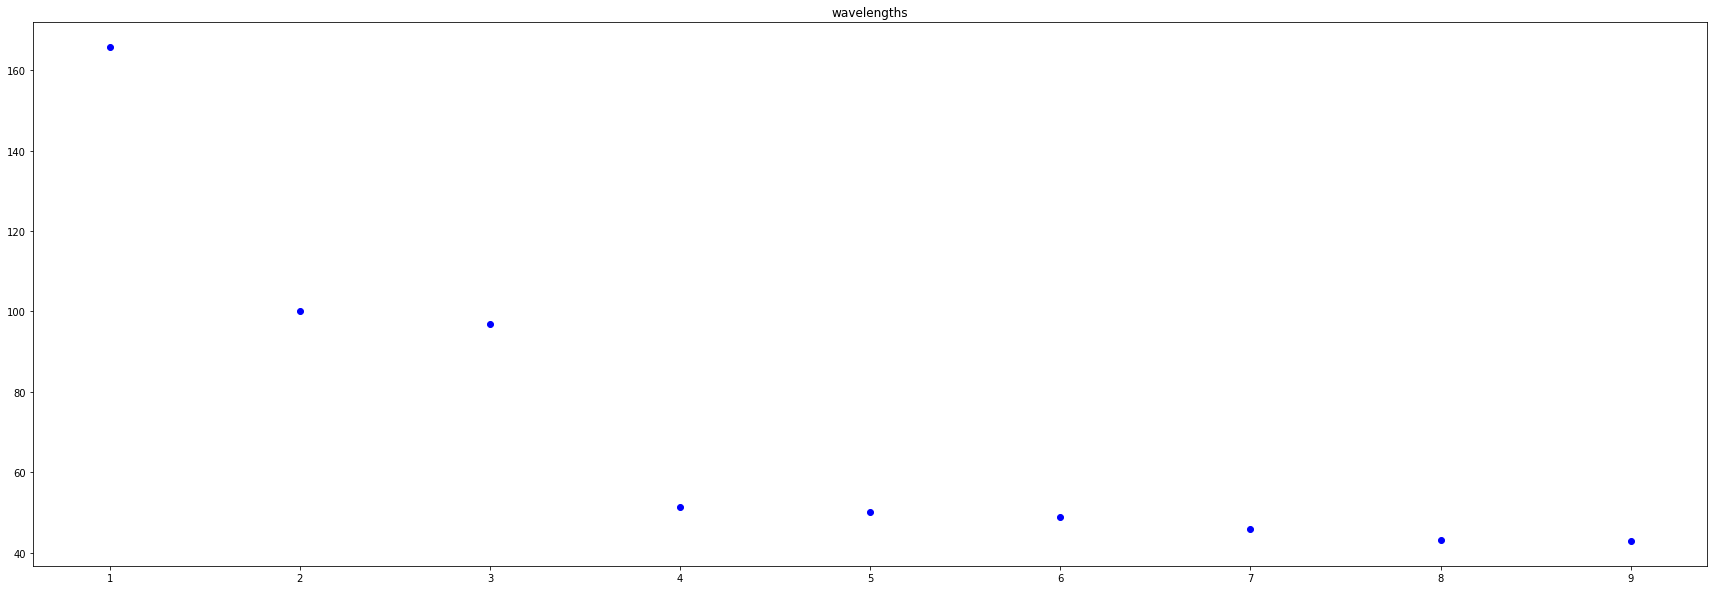

In [5]:
wavelengths = 2 * np.pi * np.reciprocal(np.sqrt(values[1:k]))

plt.scatter(range(1, k), wavelengths, color = 'blue')
plt.title('wavelengths')
plt.show()

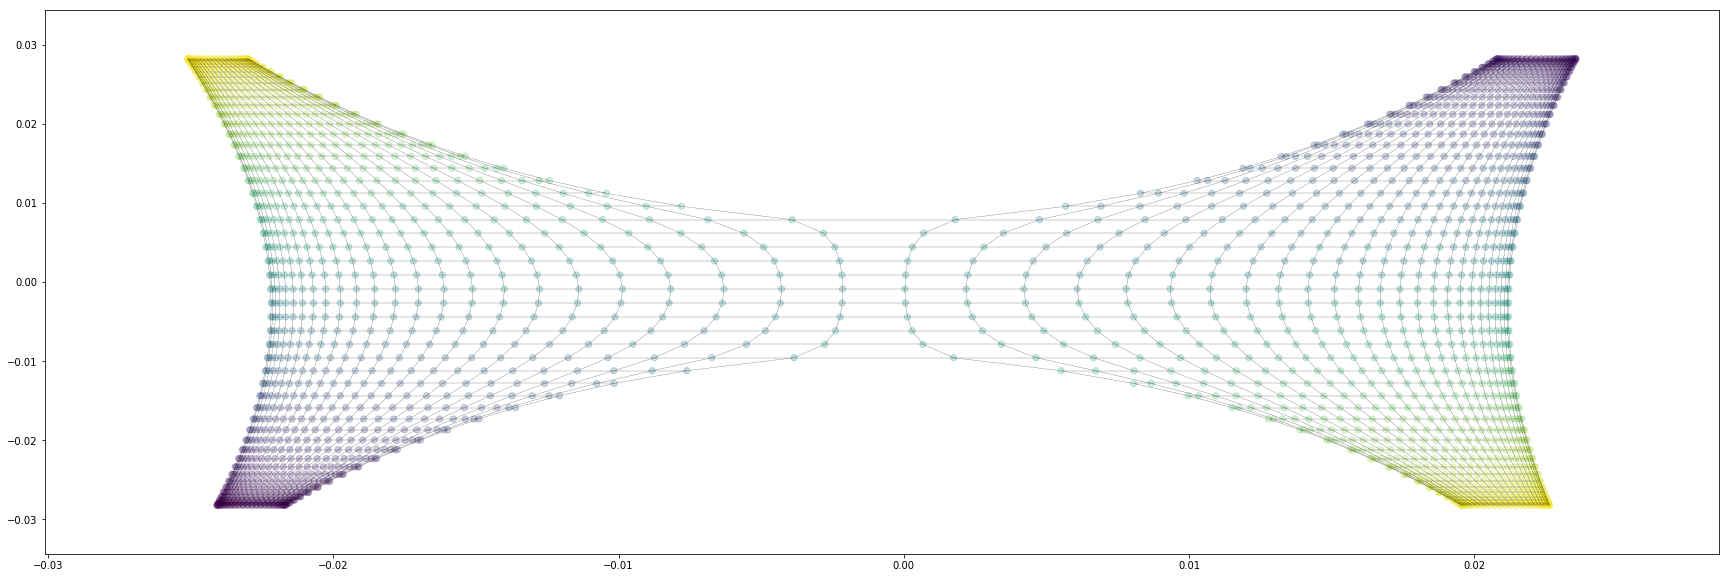

In [6]:
gs.plot_graph(vectors[:, [1, 2]], adj,
              edge_alpha=1,
              vertex_colors=vectors[:, 3])

### strong clusters, weakly connected

Now let's build some strongly connected clusters and connect them weakly. This graph will have a diameter of the same order as how many clusters. Its first few eigenvectors neatly capture the structure of the clusters 

In [7]:
how_many_clusters = 4
mean_cluster_size = 25

p = 0.75  # intracluster connection probability
q = 0.15  # additional connection probability

cluster_sizes = np.random.poisson(
    mean_cluster_size, how_many_clusters
)

adj = 0 + la.block_diag(*[np.random.random((m, m)) <= p
                          for m in cluster_sizes])

adj += np.random.random(adj.shape) <= q
adj[adj > 1] = 1  # redundant edges

In [8]:
k = 10
lap = gs.compute_laplacian(adj)
values, vectors = gs.calculate_small_eigens(lap, k)

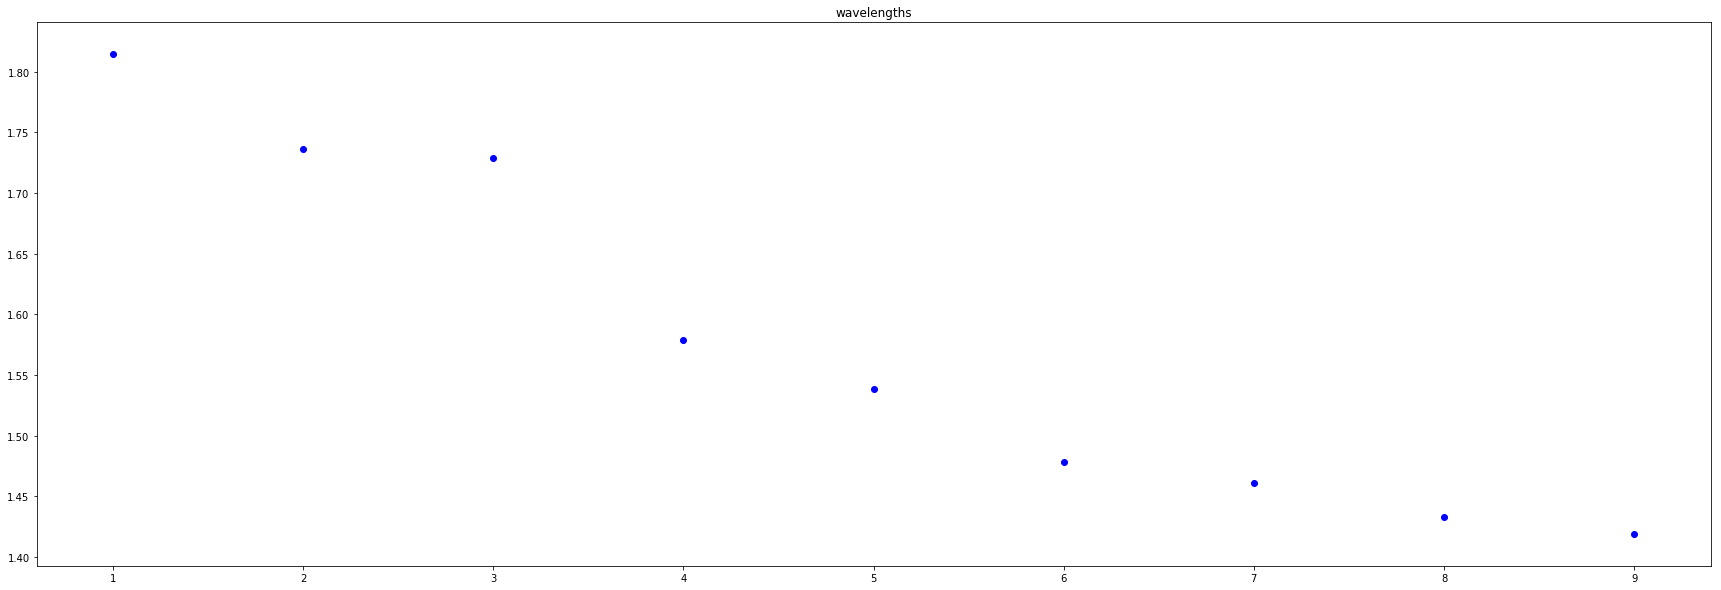

In [9]:
wavelengths = 2 * np.pi * np.reciprocal(np.sqrt(values[1:k]))

plt.scatter(range(1, k), wavelengths, color = 'blue')
plt.title('wavelengths')
plt.show()

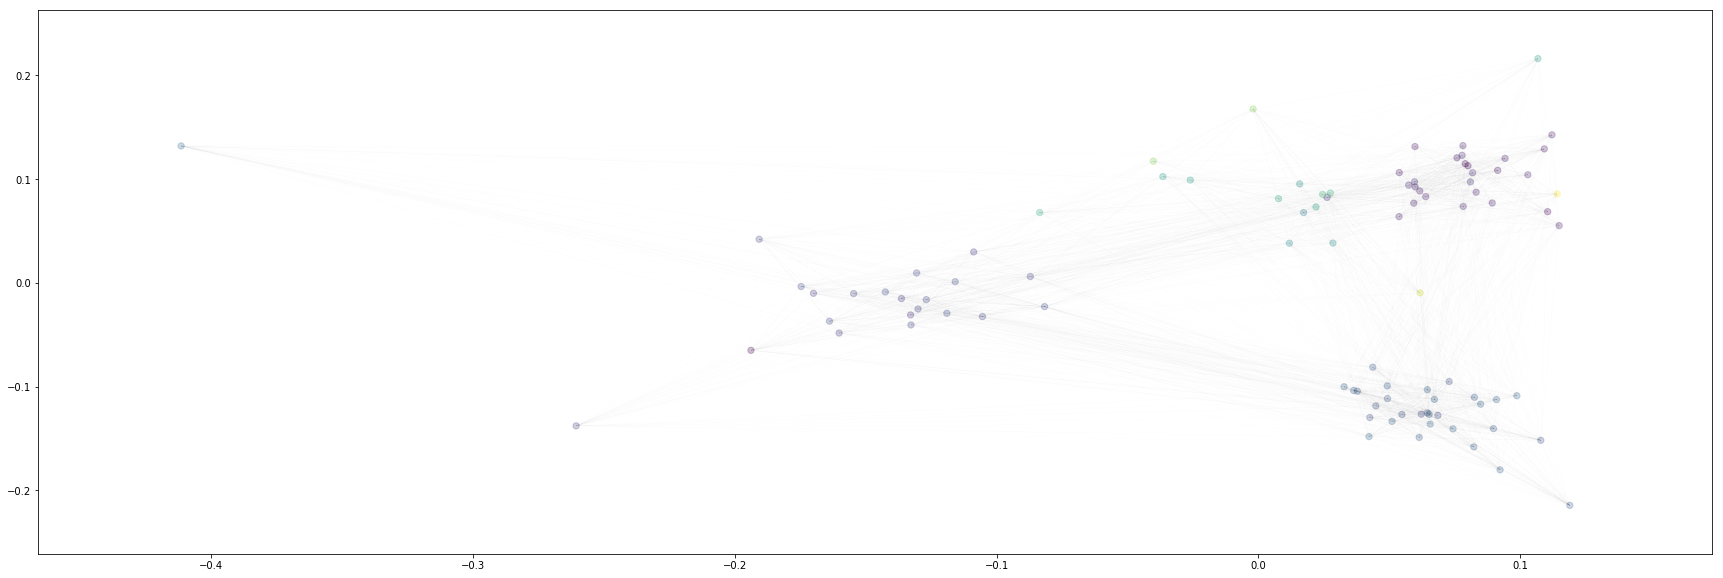

In [10]:
gs.plot_graph(vectors[:, [1, 2]], adj,
              edge_alpha = 0.05,
              vertex_colors=vectors[:, 3])

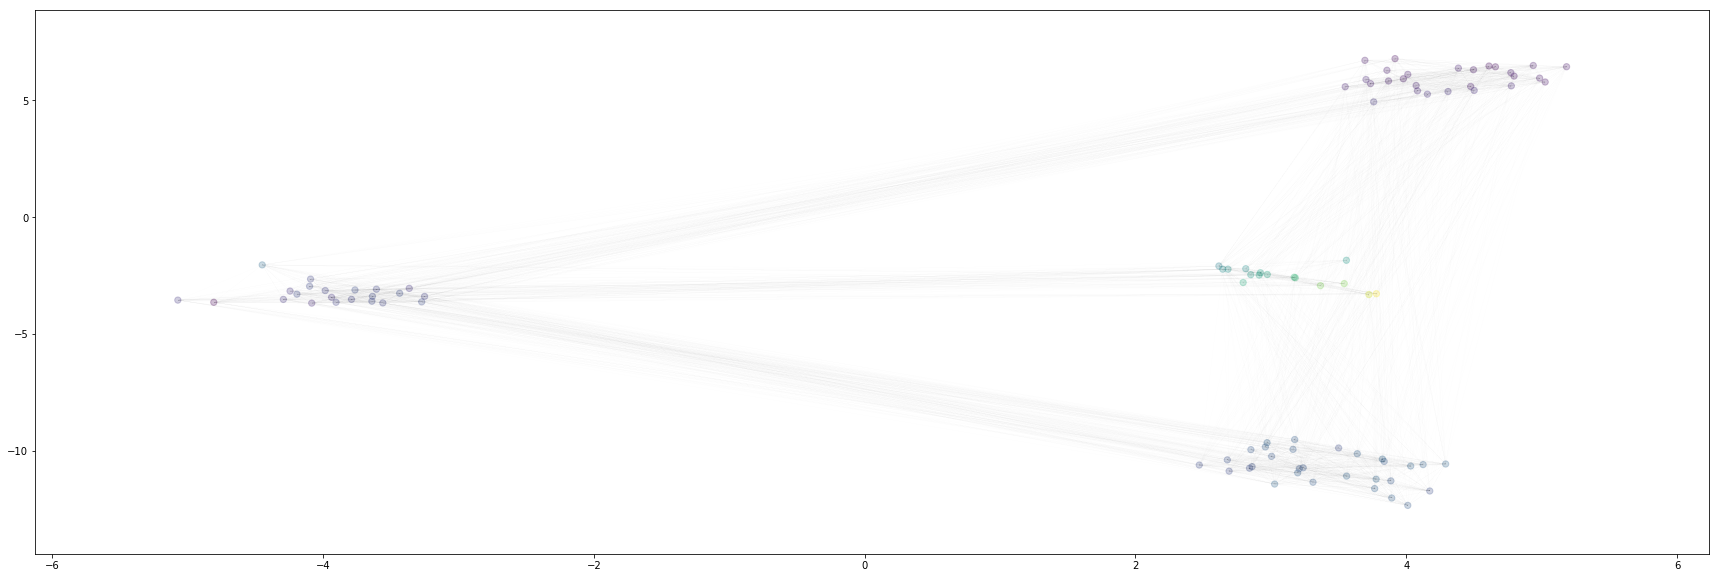

In [11]:
tsne_coords = TSNE(
    perplexity=mean_cluster_size
).fit_transform(
    vectors[:, 1:how_many_clusters]
)

gs.plot_graph(tsne_coords, adj,
              edge_alpha = 0.05,
              vertex_colors=vectors[:, 3])